In [223]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'kdd-cup-1999-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F90131%2F208170%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240410%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240410T155252Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D29305da9d38f4c2257d506a6e79592a5417caa5a752738f725a8a0aec15dc4f0b882bd0ba876939b10f7834861c6427d9e7955089add969965ad51174dfcbd381103bc2339f853115d7097186fd7572aa72d0d3e4bd7b8510fb9a41e21066b31b41a9a0c91f706832420feeec8f51279faa4fcf34af2fbf8563a152fdbcefa08b14bc7b559ccb600e941b25593783b7edd60a2360ab1a7826b27d8149fb00b65214f0860e6676b1268c17ff0bac14766799ec3ec5fe7829984c19fdf5322420406419e1836c8639302aba389f92a546c48eff680d78be36813c9ebe348a5a0445f95a61734661f238dfc07e4ef0c82f57a5e6247a94bb09b3c6606efb32eec25'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 92057549 bytes downloaded
Downloaded and uncompressed: kdd-cup-1999-data
Data source import complete.


This is the second version of my public kernel(Intrusion Detection System). ANN is also trained & tested on the dataset in this version.
I would really appreciate your feedback.

In [224]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [225]:
print(os.listdir('../input/kdd-cup-1999-data'))

['kddcup.newtestdata_10_percent_unlabeled.gz', 'typo-correction.txt', 'kddcup.testdata.unlabeled.gz', 'kddcup.testdata.unlabeled', 'kddcup.data', 'kddcup.data_10_percent.gz', 'training_attack_types', 'kddcup.data.corrected', 'kddcup.testdata.unlabeled_10_percent', 'kddcup.data_10_percent', 'corrected.gz', 'kddcup.newtestdata_10_percent_unlabeled', 'kddcup.testdata.unlabeled_10_percent.gz', 'kddcup.data.gz', 'kddcup.names', 'corrected', 'kddcup.data_10_percent_corrected']


In [226]:
with open("../input/kdd-cup-1999-data/kddcup.names",'r') as f:
    print(f.read())

back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.
duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: con

In [227]:
cols="""duration,
protocol_type,
service,
flag,
src_bytes,
dst_bytes,
land,
wrong_fragment,
urgent,
hot,
num_failed_logins,
logged_in,
num_compromised,
root_shell,
su_attempted,
num_root,
num_file_creations,
num_shells,
num_access_files,
num_outbound_cmds,
is_host_login,
is_guest_login,
count,
srv_count,
serror_rate,
srv_serror_rate,
rerror_rate,
srv_rerror_rate,
same_srv_rate,
diff_srv_rate,
srv_diff_host_rate,
dst_host_count,
dst_host_srv_count,
dst_host_same_srv_rate,
dst_host_diff_srv_rate,
dst_host_same_src_port_rate,
dst_host_srv_diff_host_rate,
dst_host_serror_rate,
dst_host_srv_serror_rate,
dst_host_rerror_rate,
dst_host_srv_rerror_rate"""

columns=[]
for c in cols.split(','):
    if(c.strip()):
       columns.append(c.strip())

columns.append('target')
#print(columns)
print(len(columns))

42


In [228]:
with open("../input/kdd-cup-1999-data/training_attack_types",'r') as f:
    print(f.read())

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos
nmap probe
perl u2r
phf r2l
pod dos
portsweep probe
rootkit u2r
satan probe
smurf dos
spy r2l
teardrop dos
warezclient r2l
warezmaster r2l




In [229]:
attacks_types = {
    'normal': 'normal',
'back': 'dos',
'buffer_overflow': 'u2r',
'ftp_write': 'r2l',
'guess_passwd': 'r2l',
'imap': 'r2l',
'ipsweep': 'probe',
'land': 'dos',
'loadmodule': 'u2r',
'multihop': 'r2l',
'neptune': 'dos',
'nmap': 'probe',
'perl': 'u2r',
'phf': 'r2l',
'pod': 'dos',
'portsweep': 'probe',
'rootkit': 'u2r',
'satan': 'probe',
'smurf': 'dos',
'spy': 'r2l',
'teardrop': 'dos',
'warezclient': 'r2l',
'warezmaster': 'r2l',
}


READING DATASET

In [230]:
path = "../input/kdd-cup-1999-data/kddcup.data_10_percent.gz"
df = pd.read_csv(path,names=columns)

#Adding Attack Type column
df['Attack Type'] = df.target.apply(lambda r:attacks_types[r[:-1]])

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,Attack Type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


In [231]:
df.shape

(494021, 43)

In [232]:
df['target'].value_counts()

target
smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64

In [233]:
df['Attack Type'].value_counts()

Attack Type
dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: count, dtype: int64

In [234]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

DATA PREPROCESSING

In [235]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [236]:
#Finding categorical features
num_cols = df._get_numeric_data().columns

cate_cols = list(set(df.columns)-set(num_cols))
cate_cols.remove('target')
cate_cols.remove('Attack Type')

cate_cols

['protocol_type', 'service', 'flag']

CATEGORICAL FEATURES DISTRIBUTION

In [237]:

def bar_graph(feature):
    df[feature].value_counts().plot(kind="bar")

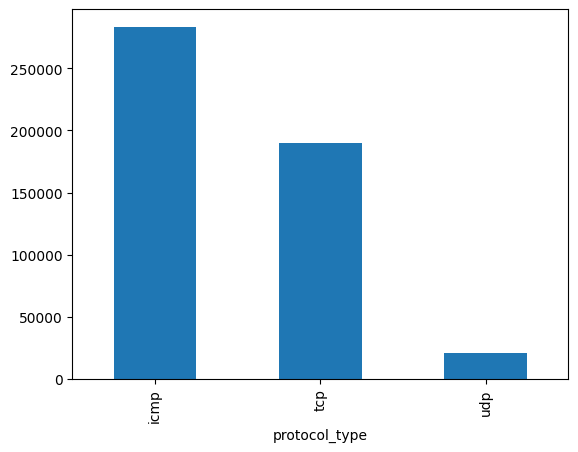

In [238]:
bar_graph('protocol_type')

Protocol type: We notice that ICMP is the most present in the used data, then TCP and almost 20000 packets of UDP type

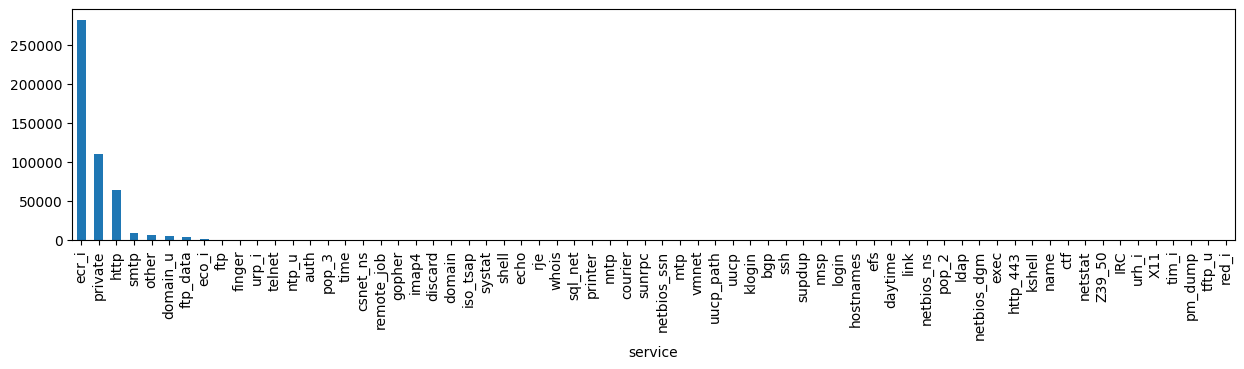

In [239]:
plt.figure(figsize=(15,3))
bar_graph('service')

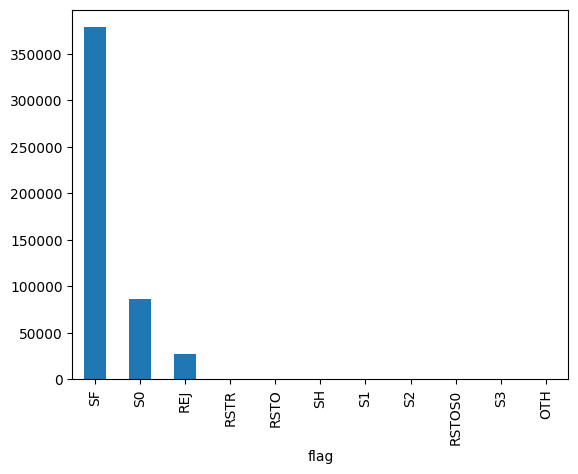

In [240]:
bar_graph('flag')

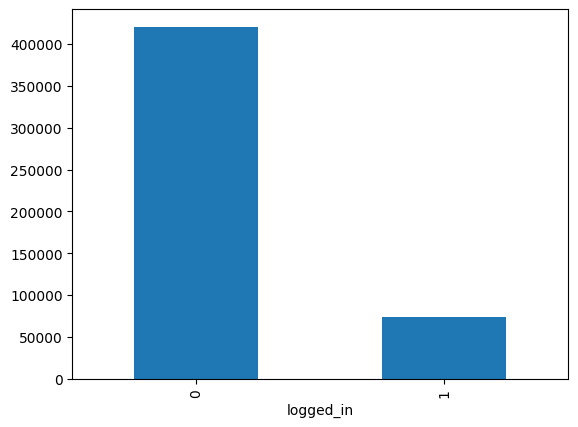

In [241]:
bar_graph('logged_in')

logged_in (1 if successfully logged in; 0 otherwise): We notice that just 70000 packets are successfully logged in.

TARGET FEATURE DISTRIBUTION

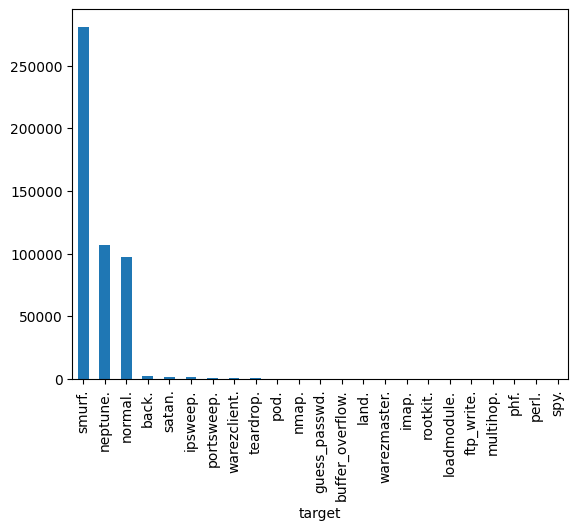

In [242]:
bar_graph('target')

Attack Type(The attack types grouped by attack, it's what we will predict)

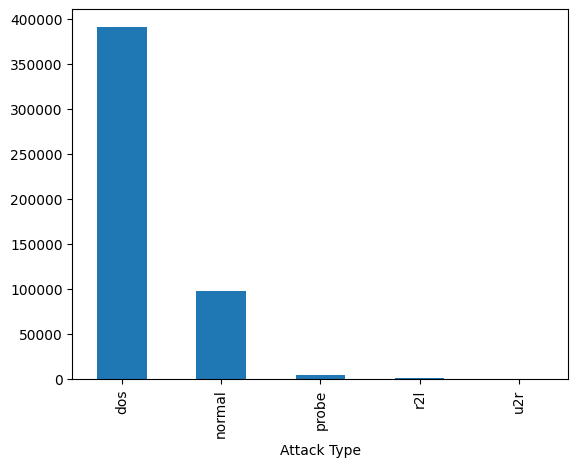

In [243]:
bar_graph('Attack Type')

In [244]:
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'target', 'Attack Type'],
      dtype='object')

DATA CORRELATION

In [245]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,Attack Type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


In [246]:
from sklearn.preprocessing import LabelEncoder

def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])

le(df)

In [247]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,Attack Type
0,0,1,22,9,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,11,1
1,0,1,22,9,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,11,1
2,0,1,22,9,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,11,1
3,0,1,22,9,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,11,1
4,0,1,22,9,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,11,1


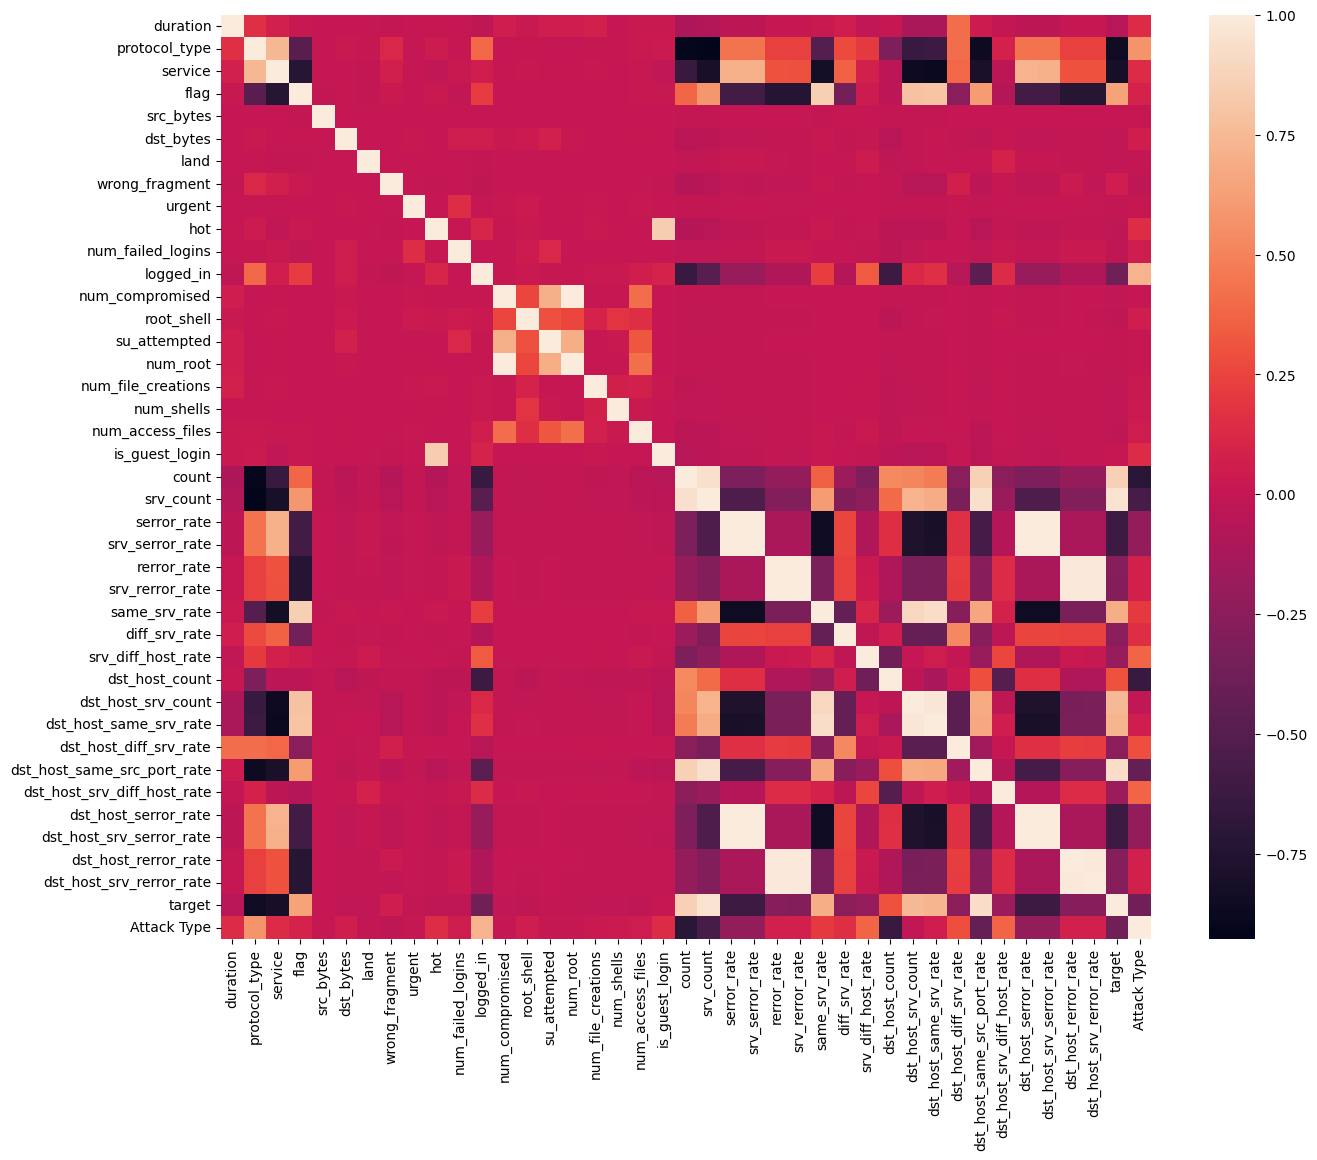

In [248]:
df = df.dropna(axis='columns')# drop columns with NaN

df = df[[col for col in df if df[col].nunique() > 1]]# keep columns where there are more than 1 unique values

corr = df.corr()

plt.figure(figsize=(15,12))

sns.heatmap(corr)

plt.show()

In [249]:
df['num_root'].corr(df['num_compromised'])

0.9938277978737916

In [250]:
df['srv_serror_rate'].corr(df['serror_rate'])

0.998361507272553

In [251]:
df['srv_count'].corr(df['count'])

0.9436670688882645

In [252]:
df['srv_rerror_rate'].corr(df['rerror_rate'])

0.9947309539818242

In [253]:
df['dst_host_same_srv_rate'].corr(df['dst_host_srv_count'])

0.9736854572953835

In [254]:
df['dst_host_srv_serror_rate'].corr(df['dst_host_serror_rate'])

0.9981559173373293

In [255]:
df['dst_host_srv_rerror_rate'].corr(df['dst_host_rerror_rate'])

0.9848038371110285

In [256]:
df['dst_host_same_srv_rate'].corr(df['same_srv_rate'])

0.9278080342690969

In [257]:
df['dst_host_srv_count'].corr(df['same_srv_rate'])

0.8989546630323716

In [258]:
df['dst_host_same_src_port_rate'].corr(df['srv_count'])

0.944926367678324

In [259]:
df['dst_host_serror_rate'].corr(df['serror_rate'])

0.9986729680104371

In [260]:
df['dst_host_serror_rate'].corr(df['srv_serror_rate'])

0.9978353003739603

In [261]:
df['dst_host_srv_serror_rate'].corr(df['serror_rate'])

0.997849248567986

In [262]:
df['dst_host_srv_serror_rate'].corr(df['srv_serror_rate'])

0.999304109185027

In [263]:
df['dst_host_rerror_rate'].corr(df['rerror_rate'])

0.986994792495618

In [264]:
df['dst_host_rerror_rate'].corr(df['srv_rerror_rate'])

0.9821663427308264

In [265]:
df['dst_host_srv_rerror_rate'].corr(df['rerror_rate'])

0.9851995540751695

In [266]:
df['dst_host_srv_rerror_rate'].corr(df['srv_rerror_rate'])

0.9865705438845764

In [267]:
#This variable is highly correlated with num_compromised and should be ignored for analysis.
#(Correlation = 0.9938277978738366)
df.drop('num_root',axis = 1,inplace = True)

#This variable is highly correlated with serror_rate and should be ignored for analysis.
#(Correlation = 0.9983615072725952)
df.drop('srv_serror_rate',axis = 1,inplace = True)

#This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9947309539817937)
df.drop('srv_rerror_rate',axis = 1, inplace=True)

#This variable is highly correlated with srv_serror_rate and should be ignored for analysis.
#(Correlation = 0.9993041091850098)
df.drop('dst_host_srv_serror_rate',axis = 1, inplace=True)

#This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9869947924956001)
df.drop('dst_host_serror_rate',axis = 1, inplace=True)

#This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
#(Correlation = 0.9821663427308375)
df.drop('dst_host_rerror_rate',axis = 1, inplace=True)

#This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9851995540751249)
df.drop('dst_host_srv_rerror_rate',axis = 1, inplace=True)

#This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
#(Correlation = 0.9865705438845669)
df.drop('dst_host_same_srv_rate',axis = 1, inplace=True)

In [268]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,target,Attack Type
0,0,1,22,9,181,5450,0,0,0,0,...,1.0,0.0,0.0,9,9,0.0,0.11,0.0,11,1
1,0,1,22,9,239,486,0,0,0,0,...,1.0,0.0,0.0,19,19,0.0,0.05,0.0,11,1
2,0,1,22,9,235,1337,0,0,0,0,...,1.0,0.0,0.0,29,29,0.0,0.03,0.0,11,1
3,0,1,22,9,219,1337,0,0,0,0,...,1.0,0.0,0.0,39,39,0.0,0.03,0.0,11,1
4,0,1,22,9,217,2032,0,0,0,0,...,1.0,0.0,0.0,49,49,0.0,0.02,0.0,11,1


In [269]:
df.shape

(494021, 33)

In [270]:
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_file_creations', 'num_shells', 'num_access_files',
       'is_guest_login', 'count', 'srv_count', 'serror_rate', 'rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'target',
       'Attack Type'],
      dtype='object')

In [271]:
df_std = df.std()
df_std = df_std.sort_values(ascending = True)
df_std

urgent                              0.005510
land                                0.006673
su_attempted                        0.007793
root_shell                          0.010551
num_shells                          0.011020
num_failed_logins                   0.015520
num_access_files                    0.036482
is_guest_login                      0.037211
dst_host_srv_diff_host_rate         0.042133
diff_srv_rate                       0.082205
num_file_creations                  0.096416
dst_host_diff_srv_rate              0.109259
wrong_fragment                      0.134805
srv_diff_host_rate                  0.142397
rerror_rate                         0.231623
logged_in                           0.355345
serror_rate                         0.380717
same_srv_rate                       0.388189
Attack Type                         0.451233
dst_host_same_src_port_rate         0.481309
protocol_type                       0.575606
hot                                 0.782103
num_compro

FEATURE MAPPING

In [272]:
df['protocol_type'].value_counts()

protocol_type
0    283602
1    190065
2     20354
Name: count, dtype: int64

In [273]:
pmap = {'icmp':0,'tcp':1,'udp':2}
df['protocol_type'] = df['protocol_type'].map(pmap)

In [274]:
df['flag'].value_counts()

flag
9     378440
5      87007
1      26875
4        903
2        579
10       107
6         57
7         24
3         11
8         10
0          8
Name: count, dtype: int64

In [275]:
fmap = {'SF':0,'S0':1,'REJ':2,'RSTR':3,'RSTO':4,'SH':5 ,'S1':6 ,'S2':7,'RSTOS0':8,'S3':9 ,'OTH':10}
df['flag'] = df['flag'].map(fmap)

In [276]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,target,Attack Type
0,0,NaN,22,NaN,181,5450,0,0,0,0,...,1.0,0.0,0.0,9,9,0.0,0.11,0.0,11,1
1,0,NaN,22,NaN,239,486,0,0,0,0,...,1.0,0.0,0.0,19,19,0.0,0.05,0.0,11,1
2,0,NaN,22,NaN,235,1337,0,0,0,0,...,1.0,0.0,0.0,29,29,0.0,0.03,0.0,11,1
3,0,NaN,22,NaN,219,1337,0,0,0,0,...,1.0,0.0,0.0,39,39,0.0,0.03,0.0,11,1
4,0,NaN,22,NaN,217,2032,0,0,0,0,...,1.0,0.0,0.0,49,49,0.0,0.02,0.0,11,1


In [277]:
df.drop('service',axis = 1,inplace= True)

In [278]:
df.shape

(494021, 32)

In [279]:
df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,target,Attack Type
0,0,NaN,NaN,181,5450,0,0,0,0,0,...,1.0,0.0,0.0,9,9,0.0,0.11,0.0,11,1
1,0,NaN,NaN,239,486,0,0,0,0,0,...,1.0,0.0,0.0,19,19,0.0,0.05,0.0,11,1
2,0,NaN,NaN,235,1337,0,0,0,0,0,...,1.0,0.0,0.0,29,29,0.0,0.03,0.0,11,1
3,0,NaN,NaN,219,1337,0,0,0,0,0,...,1.0,0.0,0.0,39,39,0.0,0.03,0.0,11,1
4,0,NaN,NaN,217,2032,0,0,0,0,0,...,1.0,0.0,0.0,49,49,0.0,0.02,0.0,11,1


In [280]:
df.dtypes

duration                         int64
protocol_type                  float64
flag                           float64
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
rerror_rate                    float64
same_srv_rate                  float64
diff_srv_rate                  float64
srv_diff_host_rate             float64
dst_host_count           

MODELLING

In [281]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [282]:
df = df.drop(['target',], axis=1)
print(df.shape)

# Target variable and train set
Y = df[['Attack Type']]
X = df.drop(['Attack Type',], axis=1)

sc = MinMaxScaler()
X = sc.fit_transform(X)

# Split test and train data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(494021, 31)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


(330994, 30) (163027, 30)
(330994, 1) (163027, 1)


DECISION TREE

In [283]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

In [284]:
model2 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [285]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')
X_train_imputed = imp.fit_transform(X_train)
model2.fit(X_train_imputed, Y_train.values.ravel())

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [286]:
# start_time = time.time()
# model2.fit(X_train, Y_train.values.ravel())
# end_time = time.time()

In [287]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')
X_train_imputed = imp.fit_transform(X_train)
start_time = time.time()
model2.fit(X_train_imputed, Y_train.values.ravel())


DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [288]:
end_time= time.time()
print("Prediction time: ", end_time-start_time)

Prediction time:  0.5204250812530518


In [289]:
# print("Training time: ", time.time() - start_time)

In [290]:
# start_time = time.time()
# model2.fit(X_train, Y_train.values.ravel())
# end_time = time.time()
# print("Training time: ", end_time-start_time)

In [291]:
# print("Training time: ",end_time-start_time)

In [292]:
start_time = time.time()
X_test_imputed = imp.transform(X_test)
Y_test_pred2 = model2.predict(X_test_imputed)
end_time = time.time()


In [293]:
print("Prediction time: ", end_time-start_time)

Prediction time:  0.1373586654663086


In [294]:
# start_time = time.time()
# Y_test_pred2 = model2.predict(X_test)
# end_time = time.time()

In [295]:
# print("Testing time: ",end_time-start_time)

In [296]:
X_train_imputed = imp.fit_transform(X_train)
X_test_imputed = imp.transform(X_test)
print("Train score is:", model2.score(X_train_imputed, Y_train))
print("Test score is:", model2.score(X_test_imputed, Y_test))

Train score is: 0.9905889532740775
Test score is: 0.9905230421954646


In [297]:
# print("Train score is:", model2.score(X_train, Y_train))
# print("Test score is:",model2.score(X_test,Y_test))

RANDOM FOREST

In [298]:
from sklearn.ensemble import RandomForestClassifier

In [299]:
model3 = RandomForestClassifier(n_estimators=30)

In [300]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')
X_train_imputed = imp.fit_transform(X_train)
X_test_imputed = imp.transform(X_test)
start_time = time.time()
model3.fit(X_train_imputed, Y_train.values.ravel())


RandomForestClassifier(n_estimators=30)

In [301]:
end_time = time.time()
print("Training time: ", end_time-start_time)

Training time:  6.7886059284210205


In [302]:
# start_time = time.time()
# model3.fit(X_train, Y_train.values.ravel())
# end_time = time.time()

In [303]:
# print("Training time: ",end_time-start_time)

In [304]:
X_test_imputed = imp.transform(X_test)
start_time = time.time()
Y_test_pred3 = model3.predict(X_test_imputed)
end_time = time.time()


In [305]:
print("Prediction time: ", end_time-start_time)

Prediction time:  0.5119144916534424


In [306]:
# start_time = time.time()
# Y_test_pred3 = model3.predict(X_test)
# end_time = time.time()

In [307]:
# print("Testing time: ",end_time-start_time)

In [308]:
X_train_imputed = imp.fit_transform(X_train)
X_test_imputed = imp.transform(X_test)
print("Train score is:", model3.score(X_train_imputed, Y_train))
print("Test score is:", model3.score(X_test_imputed, Y_test))

Train score is: 0.9999728091747887
Test score is: 0.9996442307102504


In [309]:
# print("Train score is:", model3.score(X_train, Y_train))
# print("Test score is:",model3.score(X_test,Y_test))

SUPPORT VECTOR MACHINE

In [310]:
#1
from sklearn.svm import SVC

In [311]:
#2
model4 = SVC(gamma = 'scale')

In [312]:
# #3
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')
X_train_imputed = imp.fit_transform(X_train)
X_test_imputed = imp.transform(X_test)
start_time = time.time()
model4.fit(X_train_imputed, Y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

Training time:  874.5097506046295


In [313]:
# start_time = time.time()
# model4.fit(X_train, Y_train.values.ravel())
# end_time = time.time()

In [314]:
# print("Training time: ",end_time-start_time)

In [315]:
# 4
start_time = time.time()
Y_test_pred4 = model4.predict(X_test_imputed)
end_time = time.time()
print("Prediction time: ", end_time-start_time)

Prediction time:  63.08074951171875


In [316]:
# start_time = time.time()
# Y_test_pred4 = model4.predict(X_test)
# end_time = time.time()

In [317]:
# print("Testing time: ",end_time-start_time)

In [318]:
# 5

print("Train score is:", model4.score(X_train_imputed, Y_train))
print("Test score is:", model4.score(X_test_imputed, Y_test))

Train score is: 0.9984893985993704
Test score is: 0.9986137265606311


In [319]:
# print("Train score is:", model4.score(X_train, Y_train))
# print("Test score is:", model4.score(X_test,Y_test))

Artificial Neural Network

In [320]:
# !pip install tensorflow
# !pip install scikit-learn

In [321]:
# !pip install keras --upgrade

In [322]:
# !pip install --upgrade tensorflow

In [323]:
# pip install scikeras[tensorflow]

In [324]:
# from skikeras.wrappers import KerasClassifier

In [325]:
# import tensorflow as tf
# print(tf.__version__)

In [326]:
# !pip install keras-preprocessing

In [327]:
# from sklearn.model_selection import KerasClassifier

In [328]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

def fun():
    model = Sequential()

    model.add(Dense(30, input_dim=30, activation='relu', kernel_initializer='random_uniform'))

    model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform'))

    # model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


model = fun()


In [329]:


start = time.time()
model.fit(X_train, Y_train.values.ravel(), epochs=100, batch_size=64)
end = time.time()

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


5172/5172 [==============================] - 12s 2ms/step - loss: nan - accuracy: 0.7926
Epoch 2/100
5172/5172 [==============================] - 11s 2ms/step - loss: nan - accuracy: 0.7926
Epoch 3/100
5172/5172 [==============================] - 11s 2ms/step - loss: nan - accuracy: 0.7926
Epoch 4/100
5172/5172 [==============================] - 10s 2ms/step - loss: nan - accuracy: 0.7926
Epoch 5/100
5172/5172 [==============================] - 10s 2ms/step - loss: nan - accuracy: 0.7926
Epoch 6/100
5172/5172 [==============================] - 11s 2ms/step - loss: nan - accuracy: 0.7926
Epoch 7/100
5172/5172 [==============================] - 11s 2ms/step - loss: nan - accuracy: 0.7926
Epoch 8/100
5172/5172 [==============================] - 11s 2ms/step - loss: nan - accuracy: 0.7926
Epoch 9/100
5172/5172 [==============================] - 11s 2ms/step - loss: nan - accuracy: 0.7926
Epoch 10/100
5172/5172 [==============================] - 11s 2ms/step - loss: nan - accuracy: 0.7926
E

In [330]:

print('Training time:')
print(end-start)


Training time:
1084.8149209022522


In [331]:

start_time = time.time()
Y_test_pred = model.predict(X_test)
end_time = time.time()

5095/5095 [==============================] - 7s 1ms/step


In [332]:
print("Testing time: ",end_time-start_time)

Testing time:  9.14762806892395


In [333]:

start_time = time.time()
Y_train_pred = model.predict(X_train)
end_time = time.time()


10344/10344 [==============================] - 18s 2ms/step


In [334]:
accuracy_score(Y_train, np.argmax(model.predict(X_train), axis=1))


# Y_train_pred = np.where(Y_train_pred > 0.5, 1, 0)
# Y_test_pred = np.where(Y_test_pred > 0.5, 1, 0)

# accuracy_score(Y_train, Y_train_pred)

# accuracy_score(Y_test, Y_test_pred)

10344/10344 [==============================] - 17s 2ms/step


0.7926185973159634

In [335]:
accuracy_score(Y_test, np.argmax(model.predict(X_test), axis=1))

5095/5095 [==============================] - 9s 2ms/step


0.7919301710759568

In [336]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier

In [337]:
# def fun():
#     model = Sequential()


#     model.add(Dense(30,input_dim =30,activation = 'relu',kernel_initializer='random_uniform'))


#     model.add(Dense(1,activation='sigmoid',kernel_initializer='random_uniform'))


#     model.add(Dense(5,activation='softmax'))


#     model.compile(loss ='categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

#     return model

In [338]:

# model7 = KerasClassifier(build_fn=fun,epochs=100,batch_size=64)

In [339]:
# start = time.time()
# model7.fit(X_train, Y_train.values.ravel())
# end = time.time()

In [340]:
# print('Training time')
# print((end-start))

In [341]:
# print("Testing time: ",end_time-start_time)

In [342]:
# start_time = time.time()
# Y_train_pred7 = model7.predict(X_train)
# end_time = time.time()

In [343]:
# accuracy_score(Y_train,Y_train_pred7)

In [344]:
# accuracy_score(Y_test,Y_test_pred7)

TRAINING ACCURACY

<BarContainer object of 3 artists>

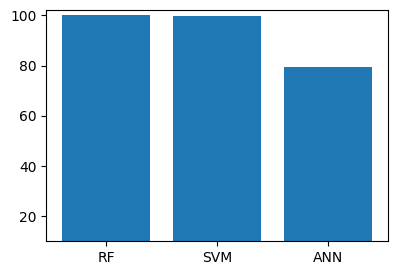

In [345]:
names = ['RF','SVM','ANN']
values = [99.997,99.849,79.265]
f = plt.figure(figsize=(15,3),num=10)
plt.subplot(131)
plt.ylim(10,102)
plt.bar(names,values)

In [346]:
f.savefig('training_accuracy_figure.png',bbox_inches='tight')

TESTING ACCURACY

<BarContainer object of 3 artists>

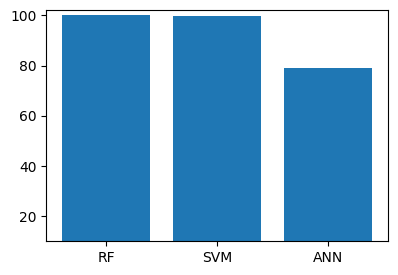

In [347]:
names = ['RF','SVM','ANN']
values = [99.969,99.869,79.193]
f = plt.figure(figsize=(15,3),num=10)
plt.subplot(131)
plt.ylim(10,102)
plt.bar(names,values)

In [348]:
f.savefig('test_accuracy_figure.png',bbox_inches='tight')

TRAINING TIME

<BarContainer object of 3 artists>

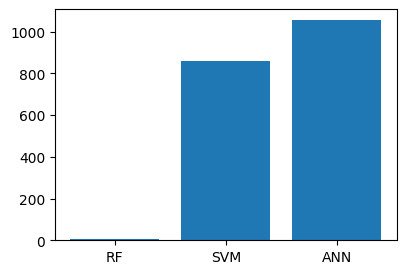

In [349]:
names = ['RF','SVM','ANN']
values = [6.62061,857.0836,1053.987]
f = plt.figure(figsize=(15,3),num=10)
plt.subplot(131)
plt.bar(names,values)

In [350]:
f.savefig('train_time_figure.png',bbox_inches='tight')

TESTING TIME

<BarContainer object of 3 artists>

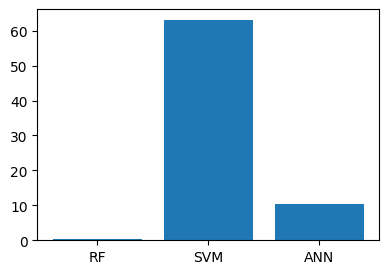

In [351]:
names = ['RF','SVM','ANN']
values = [0.48578,62.9577,10.3593]
f = plt.figure(figsize=(15,3),num=10)
plt.subplot(131)
plt.bar(names,values)

In [352]:
f.savefig('test_time_figure.png',bbox_inches='tight')

In [353]:
import joblib

In [354]:
joblib.dump(model, 'model.pkl')

['model.pkl']

CNN

In [355]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

def fun():
    model = Sequential()

    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(30,1)))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(30, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


model = fun()


start = time.time()
model.fit(X_train.reshape(-1,30,1), Y_train.values.ravel(), epochs=10, batch_size=64)
end = time.time()


print('Training time:')
print(end-start)


start_time = time.time()
Y_test_pred = model.predict(X_test.reshape(-1,30,1))
end_time = time.time()

print("Testing time: ",end_time-start_time)


start_time = time.time()
Y_train_pred = model.predict(X_train.reshape(-1,30,1))
end_time = time.time()


accuracy_score(Y_train, np.argmax(model.predict(X_train.reshape(-1,30,1)), axis=1))


accuracy_score(Y_test, np.argmax(model.predict(X_test.reshape(-1,30,1)), axis=1))

Epoch 1/10
5172/5172 [==============================] - 36s 7ms/step - loss: nan - accuracy: 0.7926
Epoch 2/10
5172/5172 [==============================] - 34s 7ms/step - loss: nan - accuracy: 0.7926
Epoch 3/10
5172/5172 [==============================] - 33s 6ms/step - loss: nan - accuracy: 0.7926
Epoch 4/10
5172/5172 [==============================] - 34s 6ms/step - loss: nan - accuracy: 0.7926
Epoch 5/10
5172/5172 [==============================] - 32s 6ms/step - loss: nan - accuracy: 0.7926
Epoch 6/10
5172/5172 [==============================] - 33s 6ms/step - loss: nan - accuracy: 0.7926
Epoch 7/10
5172/5172 [==============================] - 33s 6ms/step - loss: nan - accuracy: 0.7926
Epoch 8/10
5172/5172 [==============================] - 33s 6ms/step - loss: nan - accuracy: 0.7926
Epoch 9/10
5172/5172 [==============================] - 33s 6ms/step - loss: nan - accuracy: 0.7926
Epoch 10/10
5172/5172 [==============================] - 32s 6ms/step - loss: nan - accuracy: 0.7926

0.7919301710759568